# Predicting Median Value with Regression

This is a more reasonable application of linear regression since our target variable is also a number.

## Import Packages and Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv("/Volumes/2 TB Storage/datascience/boston_housing/exploration/data/train.csv")

## Data Wrangling

In [4]:
df.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [5]:
# check for missing values
df.isna().sum()

ID         0
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [6]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 15 columns):
ID         333 non-null int64
crim       333 non-null float64
zn         333 non-null float64
indus      333 non-null float64
chas       333 non-null int64
nox        333 non-null float64
rm         333 non-null float64
age        333 non-null float64
dis        333 non-null float64
rad        333 non-null int64
tax        333 non-null int64
ptratio    333 non-null float64
black      333 non-null float64
lstat      333 non-null float64
medv       333 non-null float64
dtypes: float64(11), int64(4)
memory usage: 39.1 KB


For obvious ethical reasons, I'm going to be leaving off black as a predictor.

In [7]:
df = df.drop('black', axis = 1)

### Fixing Data Types
Chas is the charles river dummy variable and as such needs to be converted from an int to a dummy variable. Normally this is the case, however since this variable is essentially a dummy variable already, we don't have to do that.

rad seems like it's a categorical variable..

In [8]:
df['rad'].unique()

array([ 1,  2,  3,  5,  4,  8,  6,  7, 24])

rad definitely seems like a categorical variable since there are so few unique values compared to how many observations there are. rad is an index representing accessibility to radial highways, indices are generally categorical. We will be converting rad to dummies and using those instead.

In [9]:
df['rad'] = df['rad'].astype('category')
rad_dummies = pd.get_dummies(df['rad'])
df = df.drop('rad',axis = 1)
#df = pd.concat([df, rad_dummies], axis = 1)

We're going to add the dummies after all of the processing for ease.

## Checking Distribution of Variables

We need to check the distributions of our numerical variables: crim, zn, indus, nox, rm, age, dis, tax, ptratio, black, lstat, and medv using histograms.

In [10]:
"""
check = [['crim','zn','indus'],
         ['nox','rm','age'],
         ['dis','tax','ptratio'],
         ['','lstat','medv']]
"""
check = [['crim','zn'],
        ['indus','nox'],
        ['rm','age'],
        ['dis','tax'],
        ['ptratio','lstat']]

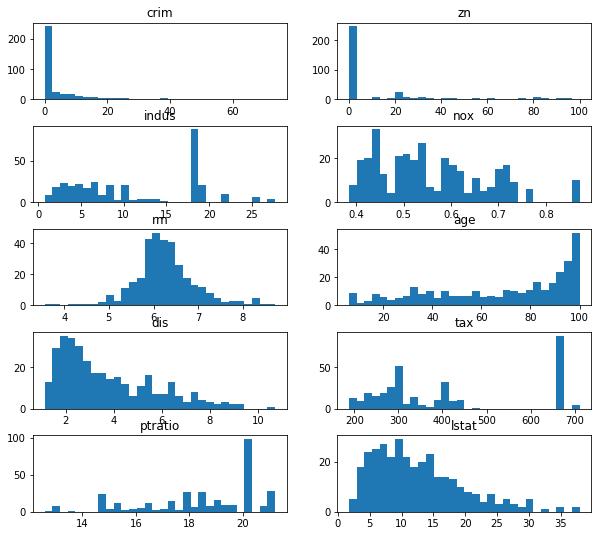

In [11]:
fig, ax = plt.subplots(5,2, figsize = (10,9))
plt.subplots_adjust(hspace=0.35)
for i in range(5):
    for j in range(2):
        ax[i,j].hist(df[check[i][j]], bins = 30)
        ax[i,j].set_title(check[i][j])

The ranges of all these values vary significantly. Therefore, we need to scale them.

In [12]:
scaler = preprocessing.StandardScaler()
unscaled_feats = df.drop(['ID','chas','medv'],axis = 1)
names = unscaled_feats.columns

scaled_feats = scaler.fit_transform(unscaled_feats)
scaled_feats = pd.DataFrame(scaled_feats, columns=names)
scaled_feats = pd.concat([scaled_feats,df['medv']],axis = 1)

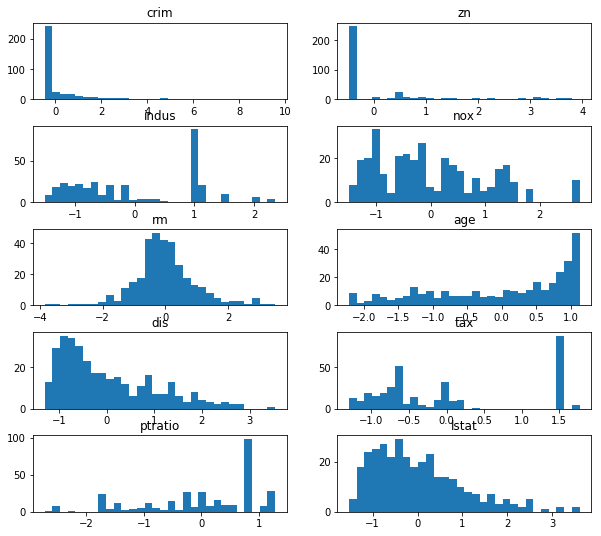

In [13]:
fig, ax = plt.subplots(5,2, figsize = (10,9))
plt.subplots_adjust(hspace=0.35)
for i in range(5):
    for j in range(2):
        ax[i,j].hist(scaled_feats[check[i][j]], bins = 30)
        ax[i,j].set_title(check[i][j])

Notice that the ranges of the data are now much more similar. Now let's put every back together.

In [14]:
scaled_feats = scaled_feats.drop('medv', axis = 1)
chas_medv = df.drop(scaled_feats.columns, axis = 1)
chas_medv = chas_medv.drop('ID', axis = 1)

features = pd.concat([scaled_feats, chas_medv, rad_dummies], axis = 1)

In [15]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 21 columns):
crim       333 non-null float64
zn         333 non-null float64
indus      333 non-null float64
nox        333 non-null float64
rm         333 non-null float64
age        333 non-null float64
dis        333 non-null float64
tax        333 non-null float64
ptratio    333 non-null float64
lstat      333 non-null float64
chas       333 non-null int64
medv       333 non-null float64
1          333 non-null uint8
2          333 non-null uint8
3          333 non-null uint8
4          333 non-null uint8
5          333 non-null uint8
6          333 non-null uint8
7          333 non-null uint8
8          333 non-null uint8
24         333 non-null uint8
dtypes: float64(11), int64(1), uint8(9)
memory usage: 34.2 KB


# Checking for Multicolinearity

We are going to look deeper into interactions between variables that have correlations greater than 0.65 as these values represent a semi-strong correlation.

In [16]:
abs_corr = features.corr().abs()
unstacked_corr = abs_corr.unstack()
sorted_corr = unstacked_corr.sort_values(kind = 'quicksort', ascending = False)

In [17]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(features, n = 16)

tax    24       0.901940
nox    dis      0.769364
age    dis      0.764208
indus  nox      0.750087
lstat  medv     0.738600
nox    age      0.736000
indus  tax      0.708313
       dis      0.702327
rm     medv     0.689598
crim   24       0.674004
nox    tax      0.670722
indus  age      0.638378
zn     dis      0.637142
crim   tax      0.617081
rm     lstat    0.615747
indus  lstat    0.614155
dtype: float64

When I say that a pair of predictors' relationship requries further exploration, I mean that I am going to look at two statistics: tolerance and variance inflation factor. These are defined as:

Tolerance = $1-r^{2}$

- Tolerance < 0.1 tend to indicate problematic relationships.

Variance Inflation Factor = $\frac{1}{\text{Tolerance}}$

- VIF > 10 tend to be problematic.

In [18]:
# Create Column Values
cor = get_top_abs_correlations(features, n = 11)
tol = 1-cor**2
vif = 1/tol

In [19]:
cor_table = pd.concat([cor,tol,vif], axis = 1)
cor_table.columns = ['Correlation','Tolerance','VIF']
cor_table

Correlation  Tolerance       VIF
tax   24       0.901940   0.186504  5.361811
nox   dis      0.769364   0.408079  2.450507
age   dis      0.764208   0.415987  2.403923
indus nox      0.750087   0.437369  2.286400
lstat medv     0.738600   0.454470  2.200365
nox   age      0.736000   0.458305  2.181955
indus tax      0.708313   0.498292  2.006854
      dis      0.702327   0.506737  1.973411
rm    medv     0.689598   0.524454  1.906743
crim  24       0.674004   0.545718  1.832448
nox   tax      0.670722   0.550131  1.817747

None of the pairwise interactions had problematic values, so we don't have to worry about engineering any of these!

# Dimensionality Reduction

We currently have over 20 predictors if we count the dummy variables. Let's do LASSO regression to see if we can reduce the amount of predictors we have.

## Lasso Regression

In [20]:
# Obtain the Lasso functions
lasso = Lasso()
lasso01 = Lasso(alpha=0.1, max_iter=10e5)
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso00001 = Lasso(alpha = 0.0001, max_iter=10e5)

In [21]:
# Create the test-train splits
X = features.drop('medv', axis = 1)
y = features['medv']
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=31)

In [22]:
# Fit Lasso Regressions
lasso.fit(X_train,y_train)
lasso01.fit(X_train,y_train)
lasso001.fit(X_train,y_train)
lasso00001.fit(X_train,y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000000.0,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
# Evaluate
used_feats = pd.Series({'1':np.sum(lasso.coef_!=0), '0.1':np.sum(lasso01.coef_!=0),'0.01':np.sum(lasso001.coef_!=0), '0.001':np.sum(lasso00001.coef_!=0)})
train_scores = pd.Series({'1':lasso.score(X_train,y_train), '0.1':lasso01.score(X_train,y_train), '0.01':lasso001.score(X_train,y_train), '0.001':lasso00001.score(X_train,y_train)})
test_scores = pd.Series({'1':lasso.score(X_test,y_test), '0.1':lasso01.score(X_test,y_test), '0.01':lasso001.score(X_test,y_test), '0.001':lasso00001.score(X_test,y_test)})

evaluation_table = pd.DataFrame({'Used Features':used_feats, 'Training Score':train_scores, 'Test Score':test_scores})
evaluation_table

,Test Score,Training Score,Used Features
0.001,0.721835,0.737105,19
0.01,0.724902,0.736713,19
0.1,0.725419,0.708203,15
1,0.649038,0.630353,3


Judging by the looks of things, 15 seems to be the optimal amount of features to use. This is because when we use 20 features, the training and test scores are pretty similar, but we have to use 4 additional features. More features means greater odds that the model will overfit and generalize less accurately. So, we will consider just using the features from lasso01.

In [24]:
lasso01_feats = X.columns[lasso01.coef_!=0]

# Model Creation

In [25]:
# Obtain the regression function
lm = LinearRegression()

In [26]:
# Get X_train, X_test, y_train, y_test using only the lasso features
lasso_X_train = X_train[lasso01_feats]
lasso_X_test = X_test[lasso01_feats]
lasso_y_train = y_train[lasso01_feats]
lasso_y_test = y_test[lasso01_feats]

In [27]:
# Fit a model
full_reg = lm.fit(X_train,y_train)
lin_reg = lm.fit(X_train, y_train)

/Users/devinthai/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [28]:
lin_reg.score(X_test,y_test)

0.7217999993989398

In [29]:
#lasso_reg.score(lasso_X_test,y_test)

In [30]:
lin_reg.coef_

array([-1.15086314,  1.30577311,  0.51867945, -1.89349415,  2.40410785,
       -0.21663605, -3.0743597 , -2.01050822, -1.60311326, -4.25440668,
        3.80746975, -4.44973574, -3.19671554,  1.11942959, -1.28308174,
       -0.32546226, -2.8638443 ,  2.64369128,  2.57567797,  5.78004074])

In [31]:
X_train.columns

Index([   'crim',      'zn',   'indus',     'nox',      'rm',     'age',
           'dis',     'tax', 'ptratio',   'lstat',    'chas',         1,
               2,         3,         4,         5,         6,         7,
               8,        24],
      dtype='object')

In [32]:
coef = lin_reg.coef_
X_col = X_train.columns

In [33]:
coef_table = pd.Series(data = coef, index = X_col)

In [35]:
coef_table = pd.DataFrame({'Coefficients':coef_table})

In [38]:
coef_table

,Coefficients
crim,-1.150863
zn,1.305773
indus,0.518679
nox,-1.893494
rm,2.404108
age,-0.216636
dis,-3.074360
tax,-2.010508
ptratio,-1.603113
lstat,-4.254407
